# Funk SVD Model

Here, the goal is to predict which games a user would like by identifying game and user similarities.  This process attempts to determine how a user would interact with a game given what we know about the user, similar users, and similar games to the ones they've played.  To start, we create a matrix of users and games that identifies user preferences for specific games. For all of the games a user hasn't ranked, we then attempt to fill in those values by running our Singular Value Decomposition model.  This allows us to "predict" a user's rating for a game, which, in turn, allows us to rank games for a specific user and identify top recommendations from the games they haven't played.

## Importing Requirements and Loading Data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pickle
from pickle import dump

from scipy.sparse import csr_matrix

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise import accuracy
from surprise.model_selection import train_test_split

In [14]:
# reading in game data
game_data = pd.read_csv('data/clean_game_data.csv')

In [15]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48844 entries, 0 to 48843
Columns: 454 entries, app_id to t_eSports
dtypes: float64(444), int64(7), object(3)
memory usage: 169.2+ MB


In [16]:
game_data.columns[0:15]

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'description', 't_1980s', 't_1990's'],
      dtype='object')

In [17]:
# convert date_releast to datetime and remove columns that are not useful for cosine similarity
game_data['date_release'] = pd.to_datetime(game_data['date_release'])
game_data.drop(columns=['app_id', 'title', 'description'], inplace=True)

In [18]:
# find NaN values in the dataset
game_data.isna().sum()

date_release        0
win                 0
mac                 0
linux               0
rating              0
                 ... 
t_World War I     238
t_World War II    238
t_Wrestling       238
t_Zombies         238
t_eSports         238
Length: 451, dtype: int64

It looks like some of the games (238) had no tags.  When those games' tags were one-hot-encoded, then, those rows ended up with nothing in the tags columns.  I will remove those games since they are only a small fraction of my dataset.

In [19]:
# removing games with no tags
game_data.dropna(inplace=True)

In [20]:
user_data = pd.read_csv('data/clean_user_data.csv')
user_recs = pd.read_csv('data/clean_recommendations.csv')

In [21]:
user_recs.head()

,app_id,helpful,funny,review_date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,1,36.3,24170,0
1,304390,4,0,2017-02-17,0,11.5,1339,1
2,1085660,2,0,2019-11-17,1,336.5,110271,2
3,703080,0,0,2022-09-23,1,27.4,112510,3
4,526870,0,0,2021-01-10,1,7.9,11046,4


In [22]:
user_recs['app_id'].nunique()

2266

In [23]:
user_recs['user_id'].nunique()

6903784

We only have user reviews for 2266 unique games.  So, many of the 48,000 games will not have any reviews.  This creates an issue for modelling.  Since we want to learn how specific users would interact with specific games, we need to know something about how user preferences toward those games.  Without any information from any user toward those games, this poses a challenge.  On the other hand, fitting a model to ~7M unique users and 48,000 games could take out a small city in computing resources, let alone my computer from 2016 (which was not top of the line at the time) could handle.  So, this provides an opportunity to reduce the dimensionality of my Utility Matrix.

# Methodology

We to accomplish two things: we want to identify which games a user is most likely to enjoy _and_ we want a way to measure whether the games identified are actually games they would enjoy.  To accomplish this, I will do the following:

- Identify users that have at least 10 reviews.  Not only does this help to reduce our dataset, it also increases the chances that we'll be able to learn meaningful traits about our users.
- Further reduce the number of users so that there is a mix of both positive and negative reviews.  Adding only users who have positive reviews, for instance, would unfairly bias the matrix to filling in all NaNs with positive reviews.
- Find the cosine similarities of all ~48,000 games to identify which games are most like the others.
- Using the cosine similarity scores, I will add 500 games that are closest in similarity to the games that have not been reviewed by users.  The idea is that we can use the known scores from the reviews to guess which games would be reviewed positively or negatively for a given user.  This will be helpful for evaluating scores later.
- Create a Utility Matrix from the known scores and the 500 games without scores (do not add in the guesses for these scores yet).
- Mask a certain number of scores from the matrix to prevent the model from "learning" from those scores.  Again, this is for evaluation purposes.
- Perform the SVD calculations, filling in the NaN values of the matrix.
- Identify a threshold (0.5) that determines positive and negative scores.
- Test to see how many of the masked values that were known are correct from the SVD calculation.
- Perform this same measure on the 500 games where we can guess the "known" scores.

# Preprocessing

Let's start by reducing our dataset of users to include only users who have given a number of reviews, and then try to find users that give both positive and negative reviews.

In [24]:
user_recs.head()

,app_id,helpful,funny,review_date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,1,36.3,24170,0
1,304390,4,0,2017-02-17,0,11.5,1339,1
2,1085660,2,0,2019-11-17,1,336.5,110271,2
3,703080,0,0,2022-09-23,1,27.4,112510,3
4,526870,0,0,2021-01-10,1,7.9,11046,4


In [25]:
# we only care about the user id, app id, and recommendation column, so we drop the rest
user_recs.drop(columns=['helpful', 'funny', 'review_date', 'hours', 'review_id'], inplace=True)

In [26]:
user_recs.head()

,app_id,is_recommended,user_id
0,975370,1,24170
1,304390,0,1339
2,1085660,1,110271
3,703080,1,112510
4,526870,1,11046


In [27]:
# number of recommenders with 10 or more recommendations from users_df
rec10 = user_data[user_data['reviews']>=10]
print('Number of unique users with 10 or more reviews:', rec10['user_id'].nunique())

Number of unique users with 10 or more reviews: 151871


In [28]:
users_with_10reviews = user_recs.merge(rec10, on='user_id')

In [29]:
users_with_10reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2505749 entries, 0 to 2505748
Data columns (total 5 columns):
 #   Column          Dtype
---  ------          -----
 0   app_id          int64
 1   is_recommended  int64
 2   user_id         int64
 3   products        int64
 4   reviews         int64
dtypes: int64(5)
memory usage: 114.7 MB


(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

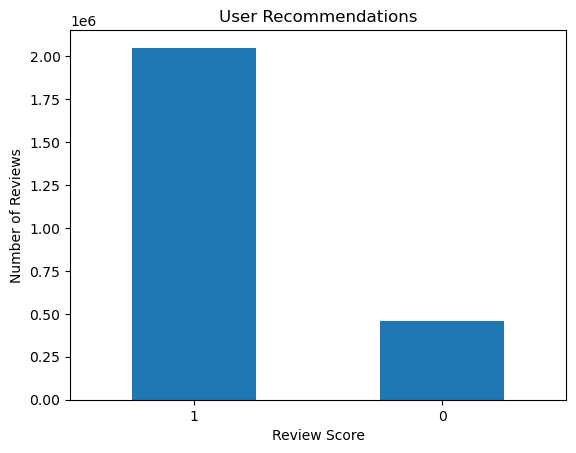

In [30]:
# let's look at the distribution of positive to negative reviews
users_with_10reviews['is_recommended'].value_counts().plot(kind='bar')
plt.title('User Recommendations')
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)

In [31]:
users_with_10reviews['user_id'].nunique()

151871

This dataset is still massively skewed toward a positive bias. We also still have 151,871 unique users.  That's way too many for my computer to be able to handle.  Let's remove users who only ever provide positive reviews and see where that gets us.  The idea is that we can learn more from users who have indicated both positive and negative preferences than those who only indicate positive preferences.  Whether this is actually the case is not clear, but since we need to reduce dimensionality somehow, this seems to be an acceptable technique. 

In [32]:
# get user total reviews and number of positive reviews
users_with_10reviews['total_reviews'] = users_with_10reviews.groupby('user_id')['is_recommended'].transform('count')
users_with_10reviews['positive_reviews'] = users_with_10reviews.groupby('user_id')['is_recommended'].transform('sum')

mixed_reviews = users_with_10reviews[users_with_10reviews['total_reviews'] != users_with_10reviews['positive_reviews']]

In [33]:
mixed_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941874 entries, 15 to 2505736
Data columns (total 7 columns):
 #   Column            Dtype
---  ------            -----
 0   app_id            int64
 1   is_recommended    int64
 2   user_id           int64
 3   products          int64
 4   reviews           int64
 5   total_reviews     int64
 6   positive_reviews  int64
dtypes: int64(7)
memory usage: 118.5 MB


In [34]:
games_reviewed = mixed_reviews['app_id'].nunique()
unique_users = mixed_reviews['user_id'].nunique()

print(f'Number of games reviewed: {games_reviewed}')
print(f'Number of uniuque users: {unique_users}')

Number of games reviewed: 2247
Number of uniuque users: 111843


Note that of the original 2266 unique games, there are now 2247.  So, by removing those ~40,000 users, we've also lost 16 games. A small price to pay. 

(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

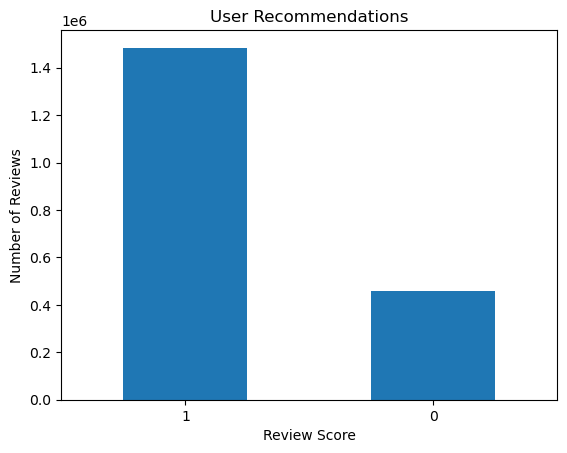

In [35]:
mixed_reviews['is_recommended'].value_counts().plot(kind='bar')
plt.title('User Recommendations')
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)

Let's work with this number for now.  Assuming my computer cannot handle an array this large (111843 x 2747), which seems likely, I will have to take further steps to reduce dimensionality.

## Game Similarity Scores

With only 2247 games out of a possible 48,000, it would be nice to find a way to increase the number of games we can recommend.  The most likely candidates are those that are similar to the 2247 games that have been reviewed.  To do this, we need to first calculate a similarity matrix (I will use the cosine similarity) to determine which games are most like these games.  I'll then iterate through the 2247 games using the following method to pick the most similar games that have not been reviewed.  This requires doing the following:

- Find the list of reviewed games and their corresponding indices in the similarity matrix.
- Iterate through this list and find the corresponding row in the similarity matrix to each game.
- Excluding the games in the reviewed games list, find the game index with the highest similarity to each game.  Add these games to a list.
- Finally, remove any duplicates from this `highest_scores` list.  

This process assumes that games not reviewed are still relatively similar to the games in the reviewed list.  In the very worst case, though, we are finding the _2248th_ most similar game since it is theoretically possible that all of the nearest neighbours to a game are those in the reviewed list.  As a final check, we can do an eye test to ensure these games have a positive similarity score.

In [36]:
game_data.head()

,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,...,t_Well-Written,t_Werewolves,t_Western,t_Wholesome,t_Word Game,t_World War I,t_World War II,t_Wrestling,t_Zombies,t_eSports
0,2008-11-18,1,0,0,1,92,37039,19.99,19.99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2008-11-21,1,0,0,1,84,2199,9.99,9.99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-08-03,1,0,0,1,85,21,2.99,2.99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-04-24,1,1,1,1,92,3722,14.99,14.99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-11-18,1,0,0,0,61,873,14.99,14.99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Note that this dataset is not scaled.  A `positive_ratio` of 92 would be weighted much higher than a `t_Well-Written` tag, for instance, since the tag is on a scale of 0-1 while the positive ratio is a scale from 0-100. So, the data must first be scaled.

The `rating` column is seemingly redundant since it reflects the data contained in the `positive_ratio` column.  This, in effect, "doubles" the weight of the rating/positive ratio, even after scaling.

The `date_release` column contains datetime data that cannot be used as-is in a cosine similarity calculation.  This is because it represents a timeseries that is not a discrete numerical value.  For this reason, I will take only the year value and convert it to an integer.

In [37]:
# drop 'rating' column
game_data.drop(columns='rating')

# set date_release to integer year value
game_data['date_release'] = game_data['date_release'].dt.year

In [38]:
# confirming data types are numerical.  We already know all tags are One-Hot encoded numerical values.
game_data.iloc[:, 0:15].dtypes

date_release        int64
win                 int64
mac                 int64
linux               int64
rating              int64
positive_ratio      int64
user_reviews        int64
price_final       float64
price_original    float64
discount          float64
t_1980s           float64
t_1990's          float64
t_2.5D            float64
t_2D              float64
t_2D Fighter      float64
dtype: object

In [39]:
# scaling the game_data
scaler = StandardScaler()
scaled_game_data = scaler.fit_transform(game_data)

In [40]:
scaled_game_data.shape , type(scaled_game_data)

((48606, 451), numpy.ndarray)

In [41]:
# I just want to see the scaled data, not as an array
scaled_game_df = game_data
scaled_game_df[scaled_game_df.columns] = scaled_game_data
scaled_game_df.head()

,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,...,t_Well-Written,t_Werewolves,t_Western,t_Wholesome,t_Word Game,t_World War I,t_World War II,t_Wrestling,t_Zombies,t_eSports
0,-3.445632,0.108058,-0.592731,-0.469465,0.925033,0.833550,0.927053,0.980415,0.911634,-0.282178,...,-0.02128,-0.043547,-0.06743,-0.052381,-0.086261,-0.049121,8.677820,-0.030101,5.849935,-0.090169
1,-3.445632,0.108058,-0.592731,-0.469465,0.925033,0.394303,0.011536,0.113638,0.066086,-0.282178,...,-0.02128,-0.043547,-0.06743,-0.052381,-0.086261,-0.049121,-0.115236,-0.030101,-0.170942,-0.090169
2,-2.464658,0.108058,-0.592731,-0.469465,0.925033,0.449209,-0.045697,-0.493107,-0.525798,-0.282178,...,-0.02128,-0.043547,-0.06743,-0.052381,-0.086261,-0.049121,-0.115236,-0.030101,-0.170942,-0.090169
3,-1.810676,0.108058,1.687105,2.130083,0.925033,0.833550,0.051557,0.547027,0.488860,-0.282178,...,-0.02128,-0.043547,-0.06743,-0.052381,-0.086261,-0.049121,-0.115236,-0.030101,-0.170942,-0.090169
4,-1.483684,0.108058,-0.592731,-0.469465,-1.081042,-0.868532,-0.023308,0.547027,0.488860,-0.282178,...,-0.02128,-0.043547,-0.06743,-0.052381,-0.086261,-0.049121,-0.115236,-0.030101,5.849935,-0.090169


In [42]:
# perform cosine similarity in batches
def cosine_similarity_n_space(data, batch_size=25):
    assert isinstance(data, np.ndarray), "Input data must be a numpy array"
    ret = np.ndarray((data.shape[0], data.shape[0]))
    for row_i in range(0, int(data.shape[0] / batch_size) + 1):
        start = row_i * batch_size
        end = min([(row_i + 1) * batch_size, data.shape[0]])
        if end <= start:
            break
        rows = data[start: end]
        sim = cosine_similarity(rows, data)  # rows is O(1) size
        ret[start: end] = sim
    return ret

In [43]:
game_similarity = cosine_similarity_n_space(scaled_game_data)

In [44]:
game_similarity

array([[ 1.00000000e+00,  9.10535553e-02,  2.36049063e-02, ...,
         3.17866335e-02,  6.65272439e-02, -4.80088447e-03],
       [ 9.10535553e-02,  1.00000000e+00,  2.52229439e-02, ...,
        -3.70276951e-05,  1.56169951e-03,  1.89940677e-01],
       [ 2.36049063e-02,  2.52229439e-02,  1.00000000e+00, ...,
        -4.74751437e-02, -8.34894899e-02, -1.39685093e-01],
       ...,
       [ 3.17866335e-02, -3.70276951e-05, -4.74751437e-02, ...,
         1.00000000e+00, -9.88260679e-03,  2.80813419e-04],
       [ 6.65272439e-02,  1.56169951e-03, -8.34894899e-02, ...,
        -9.88260679e-03,  1.00000000e+00,  7.64013333e-02],
       [-4.80088447e-03,  1.89940677e-01, -1.39685093e-01, ...,
         2.80813419e-04,  7.64013333e-02,  1.00000000e+00]])

In [45]:
game_similarity.shape

(48606, 48606)

In [46]:
mixed_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941874 entries, 15 to 2505736
Data columns (total 7 columns):
 #   Column            Dtype
---  ------            -----
 0   app_id            int64
 1   is_recommended    int64
 2   user_id           int64
 3   products          int64
 4   reviews           int64
 5   total_reviews     int64
 6   positive_reviews  int64
dtypes: int64(7)
memory usage: 118.5 MB


In [47]:
game_data_copy = pd.read_csv('data/clean_game_data.csv')
game_data_copy.drop(columns=['title', 'description'], inplace=True)
game_data_copy.dropna(inplace=True)
game_data_copy.index = range(len(game_data_copy))
game_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48606 entries, 0 to 48605
Columns: 452 entries, app_id to t_eSports
dtypes: float64(444), int64(7), object(1)
memory usage: 167.6+ MB


In [48]:
# get a list of the reviewed games and corresponding indices in game_data_copy
reviewed_games = mixed_reviews['app_id'].value_counts().index.to_list()
reviewed_games_indices = game_data_copy[game_data_copy['app_id'].isin(reviewed_games)].index.to_list()

# get a list of the unreviewed games and corresponding indices in game_data_copy
unreviewed_games_indices = game_data_copy.index[~game_data.index.isin(reviewed_games_indices)]
unreviewed_games = game_data_copy.loc[unreviewed_games_indices]

In [49]:
# make sure these match in length
(len(reviewed_games_indices), len(reviewed_games), len(unreviewed_games), len(unreviewed_games_indices))

(2247, 2247, 46367, 46367)

Now we have a list of games that have been reviewed along with their corresponding indices in the similarity matrix.  Now let's find the games that are most similar to these games so that we can add them to our recommendation matrix.  The idea is that we can add these games because we can guess that any user who reviewed the game that was the most similar to the added game would score this game in the same way. In that way, we have a test that can judge whether our matrix factorization worked correctly.

In [115]:
# find the games that are most similar to the reviewed games

def get_similar_games(reviewed_games_indices):
    highest_scores_indices = []
    highest_scores = []

    for i in reviewed_games_indices:

        similarity_scores = game_similarity[i, :]

        for index in reviewed_games_indices:
            similarity_scores[index] = np.nan

        highest_score = np.nanmax(similarity_scores)
        highest_scores.append(highest_score)

        highest_score_index = np.nanargmax(similarity_scores)
        highest_scores_indices.append(highest_score_index)

    return highest_scores_indices, highest_scores

highest_scores_indices, highest_scores = get_similar_games(reviewed_games_indices)

# drop duplicates from the indices list
highest_scores_indices = list(set(highest_scores_indices))

In [51]:
print(f'We found {len(highest_scores)} similar games, {len(highest_scores_indices)} of which were not duplicates')

# Using the statistics module to compute descriptive statistics of the highest_scores
mean_value = statistics.mean(highest_scores)
median_value = statistics.median(highest_scores)
min_value = min(highest_scores)
max_value = max(highest_scores)
standard_deviation = statistics.stdev(highest_scores)

print("Mean:", mean_value)
print("Median:", median_value)
print("Minimum value:", min_value)
print("Maximum value:", max_value)
print("Standard deviation:", standard_deviation)

We found 2247 similar games, 1938 of which were not duplicates
Mean: 0.7326894824381105
Median: 0.7229109313068636
Minimum value: 0.27149935565359506
Maximum value: 0.9999838443226213
Standard deviation: 0.1284571342576696


Having a quick look at the games we've chosen for our recommendations, we can see that they all have a positive similarity score to their corresponding reviewed game.  A few are not quite as similar as we might like, but the majority seem to be quite close, with a few almost identical according to their similarity scores.  Let's assume these are sufficient to make educated guesses for additional games that the reviewer would like (or dislike if they gave the similar game a negative rating).

Now that we have this, let's find the app_id for these games and then begin the matrix factorization process.

In [52]:
unreviewed_appIDs = []

for index in highest_scores_indices:
    #get the app_id at the highest similarity score index we just found
    unreviewed_appIDs.append(game_data_copy.loc[index, 'app_id'])

In [53]:
# confirming that none of the apps we found exist in our list of reviewed games
print(len(set(unreviewed_appIDs).intersection(set(reviewed_games))))

0


In [54]:
# knowing there are no duplicates, lets add the two together
utility_games = reviewed_games + unreviewed_appIDs
len(utility_games)

4185

## Funk SVD

Finally, we are ready to create our Utility Matrix of games and users and then calculate the missing values in the matrix.  

The matrix will describe unique users (rows) and unique games (columns), with the known values for is_recommended filling in the matrix data.  Recall that, since we only chose users with a minimum of 10 reviews, each row will have at least 10 reviews (and, therefore, at most 4175 NaN values).

For the sake of limited memory resources, let's all collectively agree to never attempt to create a sparse matrix with ~100,000 rows and ~4000 column.  Instead, we will just have to imagine what such a thing would look like.

In [55]:
# reminding myself what we are working with
mixed_reviews.head()

,app_id,is_recommended,user_id,products,reviews,total_reviews,positive_reviews
15,518790,1,117433,48,12,12,9
16,261550,1,117433,48,12,12,9
17,1824220,1,117433,48,12,12,9
18,1174180,1,117433,48,12,12,9
19,379430,1,117433,48,12,12,9


In [56]:
svd_df = mixed_reviews[['user_id', 'app_id', 'is_recommended']]

In [57]:
svd_df

,user_id,app_id,is_recommended
15,117433,518790,1
16,117433,261550,1
17,117433,1824220,1
18,117433,1174180,1
19,117433,379430,1
...,...,...,...
2505732,3201865,1593500,0
2505733,3201865,292030,1
2505734,3201865,1172380,1
2505735,3201865,236430,1


`svd_df` is formatted so that it can correctly be transformed into an SVD Dataset for the svd model.  Note, however, that it does not include the unreviewed games.  To add them, I will create a dummy user, leaving the 'is_recommended' column blank.

In [58]:
dummy_user = pd.DataFrame({
    'user_id': [9999999]*len(unreviewed_appIDs),
    'app_id': unreviewed_appIDs,
    'is_recommended': [np.nan]*len(unreviewed_appIDs)
})

In [59]:
dummy_user

,user_id,app_id,is_recommended
0,9999999,1334330,NaN
1,9999999,1730260,NaN
2,9999999,253250,NaN
3,9999999,1770830,NaN
4,9999999,736240,NaN
...,...,...,...
1933,9999999,898460,NaN
1934,9999999,2146190,NaN
1935,9999999,933300,NaN
1936,9999999,1074040,NaN


In [60]:
# add our dummy user without recommendations to our dataframe
expanded_svd_df = pd.concat([svd_df, dummy_user], ignore_index=True)

In [61]:
expanded_svd_df.to_csv('data/svd_recommendations.csv', index=False)

In [3]:
# this is simply a pickup location in case we need to run our model numerous times
expanded_svd_df = pd.read_csv('data/svd_recommendations.csv')

With everything in place, we can create the Dataset and make "predictions" for the unknown numbers in the utility matrix.

In [4]:
# preparing the data for our model
my_dataset = Dataset.load_from_df(expanded_svd_df, Reader(rating_scale=(0, 1)))
my_train_dataset = my_dataset.build_full_trainset()

### Initializing the Algorithm

In [5]:
my_algorithm = FunkSVD(n_factors=10, 
                       n_epochs=100, 
                       lr_all=0.1,    # Learning rate for each epoch
                       biased=False,  # This forces the algorithm to store all latent information in the matrices
                       verbose=0)

my_algorithm.fit(my_train_dataset)

# We can pickle our model so that it can be loaded whenever (and wherever) we need it.
dump(my_algorithm, open('svd_model.pkl','wb'))

After running the model, we can see what it has done.

In [145]:
U = my_algorithm.pu
print(U.shape)

G = my_algorithm.qi.T
print(G.shape)

(111844, 10)
(10, 4185)


So, our model has produced two matrices, one for users and one for games such that their dot product produces the utility (user-item) matrix that we are aiming for.  In order to get the dot product to produce the correct numbers in the utility matrix, it randomly initializes values and then performs a gradient descent to "pull" numbers closer to the target values.  Doing this in turn pulls unknown values toward "optimal" values as well.  These unknown values, then, are in effect the predictions for user ratings of games that they have not yet rated.

We can see how it does this for the first game below.

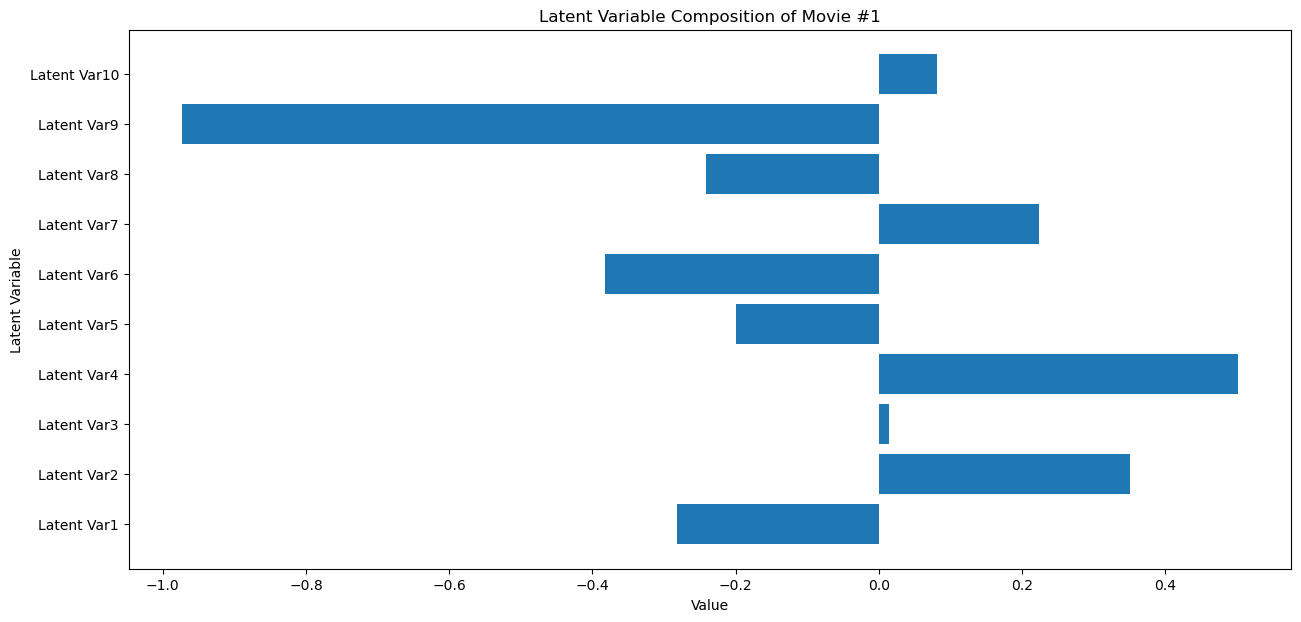

In [64]:
first_game = G[:, 0]

plt.figure(figsize=(15, 7))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_game)+1)], first_game)
plt.title("Latent Variable Composition of Game #1")
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show()

By determining latent variables for each game, it is able to "evaluate" how a user would interact with that game, given the user's own latent variables.  This gives us the final predicted score for each user-item pair.

### Matrix Factorization Results

To visualize the results of the matrix factorization, let's take our first user and see which games we know they rated.  We can then do two things to evaluate this model:
- compare the known game ratings to the corresponding matrix factorization results
- compare the guessed game ratings (the games that were added without reviews, but which are similar to the reviewed games) to the corresponding predicted game ratings.

In [149]:
# comparing known ratings to factorization results

# take the first user as our test
test_user = expanded_svd_df['user_id'].iloc[0]

def user_evaluation_known(test_user):
    # get that user's game ratings
    test_user_ratings = expanded_svd_df[expanded_svd_df['user_id']==test_user]
    rated_games = test_user_ratings['app_id'].values

    columns = ['app_id', 'actual_rating', 'predicted_rating']
    test_user_predictions = pd.DataFrame(columns=columns)

    # get predictions for each game the user has reviewed
    for game in rated_games:

        actual_rating = test_user_ratings.loc[test_user_ratings['app_id']==game, 'is_recommended'].values[0]
        predicted_rating = my_algorithm.predict(test_user, game).est

        row = {'app_id': game, 'actual_rating': actual_rating, 'predicted_rating': predicted_rating}
        test_user_predictions = pd.concat([test_user_predictions, pd.DataFrame([row])], ignore_index=True)

    # if the predicted rating is >= 0.5, we say it is 'positive', otherwise negative.  Test to see if factorization was accurate.
    test_user_predictions['accurate_rating'] = (test_user_predictions['actual_rating'] == round(test_user_predictions['predicted_rating'], 0))

    return test_user_predictions

display(user_evaluation_known(test_user))

,app_id,actual_rating,predicted_rating,accurate_rating
0,518790,1.0,0.965353,True
1,261550,1.0,1.000000,True
2,1824220,1.0,1.000000,True
3,1174180,1.0,0.830990,True
4,379430,1.0,0.929109,True
5,1672970,0.0,0.267507,True
6,761890,0.0,0.090146,True
7,589290,1.0,1.000000,True
8,1358710,0.0,0.142976,True
9,292030,1.0,0.861775,True


100% accuracy!  This is certainly misleading since it was trained on these values.  The purpose of the factorization was to get as close as possible to these known values, so we should expect that it gets them "right."  

Recall, however, that we have a sort of test set built into this model.  We determined that the unreviewed games added to our dataset were the nearest possible neighbour (among unreviewed games) to one of the games in our reviewed games list.  We assumed that any game the user had reviewed had a corresponding nearest neighbour from the unreviewed list that they would have rated in the same way.  This is a sweeping generalization, but let's see how our model does for the test users's similar games.

In [117]:
# getting the indices of our similar games
similar_games_indices, _ = get_similar_games(reviewed_games_indices)

In [142]:
# find the corresponding 'similar games' for test_user
similar_game_indices_dict = dict(zip(reviewed_games_indices, similar_games_indices))

similar_game_list = []
for i in reviewed_games_indices:
    similar_game_index = similar_game_indices_dict[i]
    similar_game = game_data_copy.iloc[i]['app_id']
    similar_game_list.append(similar_game)

similar_game_dict = dict(zip(reviewed_games, similar_game_list))

In [150]:
# finding matrix factorization results for similar games
def user_evaluation_guessed(test_user):

    test_user_ratings = expanded_svd_df[expanded_svd_df['user_id']==test_user]
    rated_games = test_user_ratings['app_id'].values

    columns = ['app_id', 'guessed_rating', 'predicted_rating']
    test_user_predictions = pd.DataFrame(columns=columns)

    for game in rated_games:
        test_user_similar_game = similar_game_dict[game]
        guessed_score = test_user_ratings.loc[test_user_ratings['app_id']==game, 'is_recommended'].values[0]

        predicted_rating = my_algorithm.predict(test_user, test_user_similar_game).est

        row = {'app_id': test_user_similar_game, 'guessed_rating': guessed_score, 'predicted_rating': predicted_rating}
        test_user_predictions = pd.concat([test_user_predictions, pd.DataFrame([row])], ignore_index=True)

    test_user_predictions['accurate_rating'] = (test_user_predictions['guessed_rating'] == round(test_user_predictions['predicted_rating'], 0))

    return test_user_predictions

display(user_evaluation_guessed(test_user))

,app_id,guessed_rating,predicted_rating,accurate_rating
0,673130,1.0,0.727326,True
1,35000,1.0,0.918548,True
2,1066180,1.0,0.597385,True
3,250180,1.0,0.586530,True
4,815450,1.0,1.000000,True
5,252610,0.0,0.997019,False
6,698700,0.0,0.721829,False
7,1148760,1.0,0.378295,False
8,285900,0.0,0.170975,True
9,261550,1.0,1.000000,True


In [144]:
# reviewing the distribution of positive to negative scores
mixed_reviews['is_recommended'].value_counts(normalize=True)

1    0.764482
0    0.235518
Name: is_recommended, dtype: float64

Here, we see that the algorithm performs much worse (probably), getting 3/12 values wrong.  Since we don't know for sure that the users would actually rate the "similar" games the same, though, we can't be sure that the guessed scores are accurate.  In addition, recall that our dataset is heavily skewed toward positive predictions.  At only 75% accuracy for this small sample set, we should note that our dataset had a 76.4% bias toward positive reviews.  So, in that context, it did slightly worse than expected.

Of course, this is not a complete evaluation, nor is it even a particularly fair one, since we guessed the correct values where there were none to begin with.  It is simply a single user eye-test, for which we saw that the model performed _decently_.

Now that we've performed this eye test, let's try to be a little more precise.  We can evaluate the model by creating a train-test split and calculating a RMSE between the matrix's known values and the predicted values.

### Evaluating the Model

Let's start by reloading our data and creating the train/test split before retraining the model.  Following this, we can evaluate the model's accuracy.

In [151]:
# restarting from our save point
evaluation_df = pd.read_csv('data/svd_recommendations.csv')

In [163]:
# for evaluation purposes, we will have to drop the unreviewed games
evaluation_df.dropna(inplace=True)

In [184]:
# preparing the data for our model
my_dataset = Dataset.load_from_df(evaluation_df, Reader(rating_scale=(0, 1)))

# The surprise package doesn't allow you to test on the trainset we built
my_train_dataset, my_test_dataset = train_test_split(my_dataset, test_size=0.5)

svd_eval_model = FunkSVD(n_factors=10, 
                       n_epochs=100, 
                       lr_all=0.1,    # Learning rate for each epoch
                       biased=False,
                       verbose=0)

svd_eval_model.fit(my_train_dataset)

# pickle our results
dump(svd_eval_model, open('svd_eval_model.pkl','wb'))

# get predictions
predictions = svd_eval_model.test(my_test_dataset)

From this model, we can get various prediction scores.

In [185]:
# Root Mean Squared Error
RMSE = accuracy.rmse(predictions, verbose=False)
# Mean Squared Error
MSE = accuracy.mse(predictions, verbose=False)
# Mean Absolute Error
MAE = accuracy.mae(predictions, verbose=False)
# Fraction of Concordant Pairs
FCP = accuracy.fcp(predictions, verbose=False)

print(f'RMSE: {RMSE} (lower is better)')
print(f'MSE: {MSE} (lower is better)')
print(f'MAE: {MAE} (lower is better)')
print(f'FCP: {FCP} (higher is better)') 

RMSE: 0.4553673320763824 (lower is better)
MSE: 0.20735940712236234 (lower is better)
MAE: 0.3345130901876966 (lower is better)
FCP: 0.5708414901425816 (higher is better)


The prediction scores mostly tell us that the model is able generally predict the correct scores, but will frequently get the wrong score.  For instance, for a given pair of items, it can predict the correct ordering of those items (one being more positive) approximately 60% of the time.  This doesn't tell, though, that it gets the wrong prediction 40% of the time, only that when distinguishing between two items, it tends to sort them in the wrong order about 40% of the time (although it may still accurately predict both as a positive (1) or negative (0) score).

In [182]:
# Root Mean Squared Error
RMSE = accuracy.rmse(predictions, verbose=False)
# Mean Squared Error
MSE = accuracy.mse(predictions, verbose=False)
# Mean Absolute Error
MAE = accuracy.mae(predictions, verbose=False)
# Fraction of Concordant Pairs
FCP = accuracy.fcp(predictions, verbose=False)

print(RMSE)
print(MSE)
print(MAE)
print(FCP) 

0.4544546766766334
0.20652905315326342
0.33348374653865853
0.5703581851473443


In [11]:
expanded_svd_df.head()

,user_id,app_id,is_recommended
0,117433,518790,1.0
1,117433,261550,1.0
2,117433,1824220,1.0
3,117433,1174180,1.0
4,117433,379430,1.0


In [12]:
expanded_svd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943812 entries, 0 to 1943811
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   app_id          int64  
 2   is_recommended  float64
dtypes: float64(1), int64(2)
memory usage: 44.5 MB


In [43]:
user_id = 117433

played_games = expanded_svd_df[expanded_svd_df['user_id'] == user_id]

played_games = played_games['app_id'].tolist()

all_games_list = expanded_svd_df['app_id'].unique().tolist()

unplayed_games = [game for game in all_games_list if game not in played_games]

len(unplayed_games)

4173

In [23]:
len(unplayed_games)

1943800

In [45]:

with open('svd_model.pkl', 'rb') as file:
    svd_model = pickle.load(file)

# preparing the data for our model
my_dataset = Dataset.load_from_df(expanded_svd_df, Reader(rating_scale=(0, 1)))
my_train_dataset = my_dataset.build_full_trainset()

predictions = []

for game in unplayed_games:

    prediction = svd_model.predict(user_id, game).est
    predictions.append((game, prediction))

# Sort the predictions based on the estimated rating (prediction[1]) in descending order (highest to lowest)
sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

# Get the top 10 appIDs (games) from the sorted predictions
top10_appIDs = [prediction[0] for prediction in sorted_predictions[:10]]

print(top10_appIDs)





[232090, 284160, 1449850, 1203220, 1245620, 1592190, 253710, 881100, 206480, 254700]


In [16]:
predictions

0.9653530622771911